# Assignment 1
This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.

### Environment setup

The following code reads the train and test data (provided along with this template) and outputs the data and labels as numpy arrays. Use these variables in your code.

---
#### Note on conventions
In mathematical notation, the convention is tha data matrices are column-indexed, which means that a input data $x$ has shape $[d, n]$, where $d$ is the number of dimensions and $n$ is the number of data points, respectively.

Programming languages have a slightly different convention. Data matrices are of shape $[n, d]$. This has the benefit of being able to access the ith data point as a simple `data[i]`.

What this means is that you need to be careful about your handling of matrix dimensions. For example, while the covariance matrix (of shape $[d,d]$) for input data $x$ is calculated as $(x-u)(x-u)^T$, while programming you would do $(x-u)^T(x-u)$ to get the correct output shapes.

In [113]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_data, train_labels = read_data("sample_train.csv")
test_data, test_labels = read_data("sample_test.csv")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


# Questions
---
## 1.3.1 Representation
The next code cells, when run, should plot the eigen value spectrum of the covariance matrices corresponding to the mentioned samples. Normalize the eigen value spectrum and only show the first 100 values.

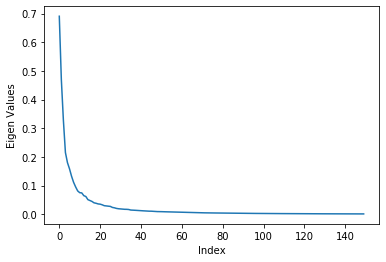

RANK = 12


In [114]:
# Samples corresponding to the last digit of your roll number (plot a)
# My roll number is 20171017, hence the last digit is

data_points = train_data[train_labels == 7]
covariance_matrix = np.cov(data_points.transpose())
eigen_values, eigen_vector = np.linalg.eig(covariance_matrix)
normalised_eigen_values = (eigen_values.real) / np.linalg.norm(eigen_values)
sorted_eigen_values = np.sort(normalised_eigen_values)
sorted_eigen_values = sorted_eigen_values[::-1]
plt.plot(sorted_eigen_values[:150])
plt.xlabel("Index")
plt.ylabel("Eigen Values")
plt.show()

## Approximate Ranks
cutoff = 0.099 * np.amax(eigen_values.real)
eigen_values[(eigen_values.real < cutoff)] = 0
print("RANK = {}".format(np.linalg.matrix_rank(np.diag(eigen_values.real))))

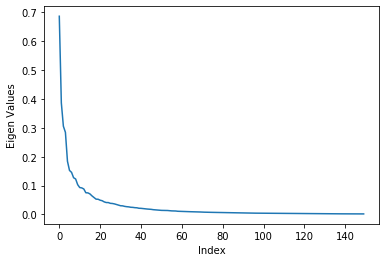

RANK = 16


In [115]:
# Samples corresponding to the last digitof (your roll number + 1) % 10 (plot b)
data_points = train_data[train_labels == 8]
covariance_matrix = np.cov(data_points.transpose())
eigen_values, eigen_vector = np.linalg.eig(covariance_matrix)
normalised_eigen_values = (eigen_values.real) / np.linalg.norm(eigen_values)
sorted_eigen_values = np.sort(normalised_eigen_values)
sorted_eigen_values = sorted_eigen_values[::-1]
plt.plot(sorted_eigen_values[:150])
plt.xlabel("Index")
plt.ylabel("Eigen Values")
plt.show()

## Approximate Ranks
cutoff = 0.099 * np.amax(eigen_values.real)
eigen_values[(eigen_values.real < cutoff)] = 0
print("RANK = {}".format(np.linalg.matrix_rank(np.diag(eigen_values.real))))

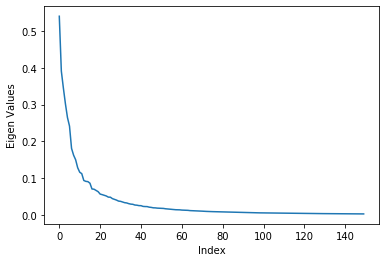

RANK = 22


In [116]:
# All training data (plot c)
data_points = train_data
covariance_matrix = np.cov(data_points.transpose())
eigen_values, eigen_vector = np.linalg.eig(covariance_matrix)
normalised_eigen_values = (eigen_values.real) / np.linalg.norm(eigen_values)
sorted_eigen_values = np.sort(normalised_eigen_values)
sorted_eigen_values = sorted_eigen_values[::-1]
plt.plot(sorted_eigen_values[:150])
plt.xlabel("Index")
plt.ylabel("Eigen Values")
plt.show()

## Approximate Ranks
cutoff = 0.099 * np.amax(eigen_values.real)
eigen_values[(eigen_values.real < cutoff)] = 0
print("RANK = {}".format(np.linalg.matrix_rank(np.diag(eigen_values.real))))

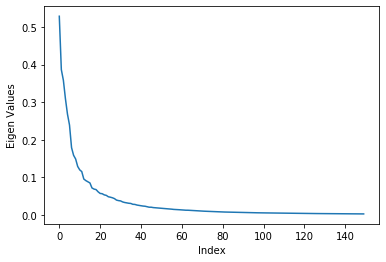

RANK = 23


In [117]:
# Randomly selected 50% of the training data (plot d)
data = np.random.randint(0, 6000, 3000)
data_points = train_data[data]
covariance_matrix = np.cov(data_points.transpose())
eigen_values, eigen_vector = np.linalg.eig(covariance_matrix)
normalised_eigen_values = (eigen_values.real) / np.linalg.norm(eigen_values)
sorted_eigen_values = np.sort(normalised_eigen_values)
sorted_eigen_values = sorted_eigen_values[::-1]
plt.plot(sorted_eigen_values[:150])
plt.xlabel("Index")
plt.ylabel("Eigen Values")
plt.show()

## Approximate Ranks
cutoff = 0.099 * np.amax(eigen_values.real)
eigen_values[(eigen_values.real < cutoff)] = 0
print("RANK = {}".format(np.linalg.matrix_rank(np.diag(eigen_values.real))))

### 1.3.1 Question 1
- Are plots a and b different? Why?
- Are plots b and c different? Why?
- What are the approximate ranks of each plot?

---
### Answers
- The plots (a) and (b) are not very different with only slight differences, since both of them represent eigen values corresponding to only one class each, that is, the class corresponding to digit 7 and digit 8 respectively.
- The plots (b) and (c) are different. This is because plot b represents eigenvalues corresponding to the covariance matrix of a single class, whereas plot c has eigenvalues corresponding to the covariance matrix of all the 10 classes. So, the distribution will change and the plots will be different.
- The ranks of the plots have been considered in such a way that the values which are less that 9.9% of the maximum eigen value are set to zero.
  - a. Rank = 12
  - b. Rank = 16
  - c. Rank = 22
  - d. Rank = 23
---

### 1.3.1 Question 2
- How many possible images could there be?
- What percentage is accessible to us as MNIST data?
- If we had acces to all the data, how would the eigen value spectrum of the covariance matrix look?

---
### Answers
- The number of possible images are 2<sup>784</sup>.
- The percentage of data accessible to us as MNIST data is (7000 / 2<sup>784</sup>) * 100 = 6.879889x10<sup>-231</sup>%
- If we had access to all data, the eigen value spectrum will be perpendicular and linear to the axis corresponding to the magnitude, as we will have non-zero eigen values along every dimension and the variance would be same along all components, and also their magnitudes will be the same.
---

## 1.3.2 Linear Transformation
---
### 1.3.2 Question 1
How does the eigen spectrum change if the original data was multiplied by an orthonormal matrix? Answer analytically and then also validate experimentally.

---
- Let us assume that the data is X with dimensions n x d, with matrix X having a mean of zero, for the sake of convenience.
- We multiple an orthonormal matrix with the data matrix, that is, X with O, to give us a matrix XO.
- As orthonormal matrices preserve lengths, mean is still zero.
- The covariance matrix of the data matrix is XX<sup>T</sup>
- C = XX<sup>T</sup> and that is equal to VLV<sup>-1</sup>, by eigen decomposition, and where V is the matrix of the eigen vectors and L is a matrix with eigen values as the diagonal elements.
- The covariance matrix after multiplicaton is as given below:
    - C<sup>new</sup> = (XO)(XO)<sup>T</sup> = XOO<sup>T</sup>X<sup>T</sup>
    - Here, OO<sup>T</sup> is an identity matrix because since O is an orthonormal matrix 
- Hence, the new covariance matrix is the same as the original covaiance matrix, that is, XX<sup>T</sup>
- Therefore, the egen spectrum would remain the same.
---

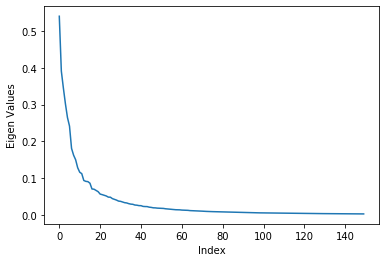

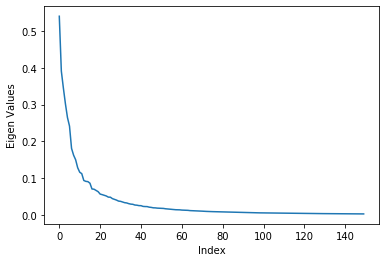

The difference in the eigen values of the data and the transformed data is minimal = 3.4300115317654317e-15


In [118]:
# Experimental validation here.
# Multiply your data (train_data) with an orthonormal matrix and plot the
# eigen value specturm of the new covariance matrix.

matrix = np.random.rand(784, 784)
orthonormal_transpose, right_upper = np.linalg.qr(matrix)
orthonormal_matrix = np.transpose(orthonormal_transpose)
data = (train_data)
resultant_matrix = np.dot(data, orthonormal_matrix)

covariance_matrix = np.cov(np.transpose(resultant_matrix))
eigen_values, eigen_vector = np.linalg.eig(covariance_matrix)
normalised_eigen_values = (eigen_values.real) / np.linalg.norm(eigen_values)
sorted_eigen_values = np.sort(normalised_eigen_values)
sorted_eigen_values = sorted_eigen_values[::-1]
plt.plot(sorted_eigen_values[:150])
plt.xlabel("Index")
plt.ylabel("Eigen Values")
plt.show()

covariance_matrix_1 = np.cov(np.transpose(train_data))
eigen_values_1, eigen_vector_1 = np.linalg.eig(covariance_matrix_1)
normalised_eigen_values_1 = (eigen_values_1.real) / np.linalg.norm(eigen_values_1)
sorted_eigen_values_1 = np.sort(normalised_eigen_values_1)
sorted_eigen_values_1 = sorted_eigen_values_1[::-1]
plt.plot(sorted_eigen_values_1[:150])
plt.xlabel("Index")
plt.ylabel("Eigen Values")
plt.show()

L2_norm = np.linalg.norm(abs(sorted_eigen_values - sorted_eigen_values_1))

print("The difference in the eigen values of the data and the transformed data is minimal = {0}".format(L2_norm))


### 1.3.2 Question 2
If  samples  were  multiplied  by  784 × 784  matrix  of rank 1 or 2, (rank deficient matrices), how will the eigen spectrum look like?

---
- Considering a data matrix with zero mean (for convenience). The data matrix is multiplied with a low rank matrix, say with a rank **m**.
- When the matrices are multiplied, the resultant matrix will have a rank which is the minimum of both the initial ranks, that is:
         rank(AB) = min(rank(A), rank(B))
- Using SVD, X' = UDV<sup>T</sup>, who rank will be atmost **m**, which implies that the maximum number of non-zero eigen values will be **m**. Here, U and V are orthogonal matrices.
- The covariance matrix is given as the follows:
   - C' = X'X'<sup>T</sup> = (UDV<sup>T</sup>)(UDV<sup>T</sup>)<sup>T</sup> = UDV<sup>T</sup>VD<sup>T</sup>U<sup>T</sup> = UPU<sup>-1</sup>, where P = DD<sup>T</sup>
   - This is eigen decomposition of C', and P is a diagonal matrix with **a** maximum number of non-zero diagonal values, which is the rank of the covariance matrix.
- Hence, the eigen spectrum will have at most **m** non-zero eigen values.
- Therefore, when a is 1 or 2, the eigen spectrum will have at most 1 or 2 non-zero eigen values respectively.

---

### 1.3.2 Question 3
Project the original data into the first and second eigenvectors and plot in 2D

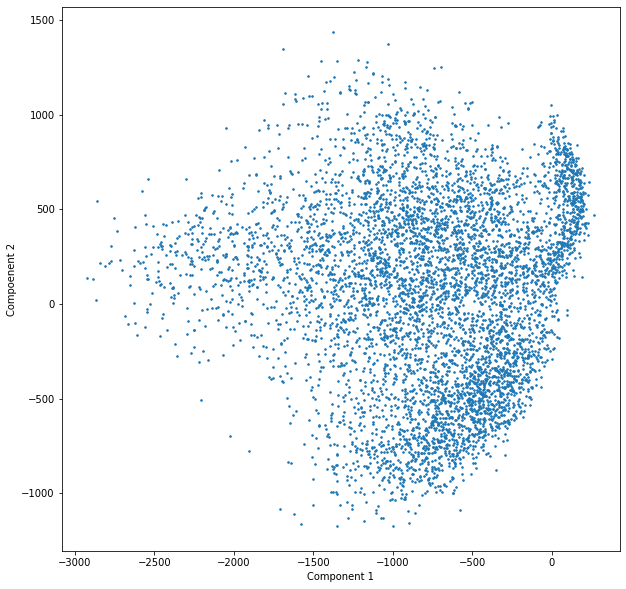

In [119]:
data_points = train_data
covariance_matrix = np.cov(data_points.transpose())

eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)
eigen_vectors = eigen_vectors[:,::-1]

property_1 = eigen_vectors[:, 0]
property_2 = eigen_vectors[:, 1]

project_data_1 = np.dot(train_data, property_1)
project_data_2 = np.dot(train_data, property_2)

plt.figure(figsize = (10, 10))
plt.scatter(project_data_1, project_data_2, s = 2.5)
plt.xlabel("Component 1")
plt.ylabel("Compoenent 2")
plt.show()

## 1.3.3 Probabilistic View
---
In this section you will classify the test set by fitting multivariate gaussians on the train set, with different choices for decision boundaries. On running, your code should print the accuracy on your test set.

In [120]:
# Print accuracy on the test set using MLE
from math import pi

number_of_digits = 10
mean_matrix = []
inverse_covariance_matrix = []
dimension = []
determinant_matrix = []

for i in range(number_of_digits):
    data_points  = train_data[train_labels == i]
    mean_data = np.mean(data_points, axis = 0)
    mean_matrix.append(mean_data)
    covariance_data = (1 / data_points.shape[0]) * (np.dot(np.transpose((data_points - mean_data)), (data_points - mean_data)))
    inverse_covariance_data = np.linalg.pinv(covariance_data)
    inverse_covariance_matrix.append(inverse_covariance_data)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_data)
    determinant = 0
    d = 0
    
    for x in eigen_values:
        if(x > 0):
            determinant += np.log(x.real)
            d += 1
    dimension.append(d)
    determinant_matrix.append(determinant)
    
correct = 0
for i in range(test_labels.shape[0]):
    possibilities = []
    for j in range(number_of_digits):
        exp_power = np.matmul(np.matmul(np.transpose(test_data[i] - mean_matrix[j]), inverse_covariance_matrix[j]), (test_data[i] - mean_matrix[j])) 
        log_p = -(1/2) * (dimension[j] * np.log(2 * pi) + determinant_matrix[j]) - (1/2) * exp_power 
        possibilities.append(log_p)
    final_prediction = np.argmax(possibilities)
    if final_prediction == test_labels[i]:
        correct = correct + 1

print('Accuracy: {0}%'.format((correct / test_labels.shape[0]) * 100))

Accuracy: 74.2%


In [121]:
# Print accuracy on the test set using MAP
from math import pi

number_of_digits = 10
mean_matrix = []
inverse_covariance_matrix = []
dimension = []
determinant_matrix = []
apriori = []

for i in range(number_of_digits):
    data_points  = train_data[train_labels == i]
    p = 0.1
    apriori.append(p)
    mean_data = np.mean(data_points, axis = 0)
    mean_matrix.append(mean_data)
    covariance_data = (1 / data_points.shape[0]) * (np.dot(np.transpose((data_points - mean_data)), (data_points - mean_data)))
    inverse_covariance_data = np.linalg.pinv(covariance_data)
    inverse_covariance_matrix.append(inverse_covariance_data)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_data)
   
    determinant = 0
    d = 0
    
    for x in eigen_values:
        if(x > 0):
            determinant += np.log(x.real)
            d += 1
    dimension.append(d)
    determinant_matrix.append(determinant)
    
correct = 0
for i in range(test_labels.shape[0]):
    possibilities = []
    for j in range(number_of_digits):
        exp_power = np.matmul(np.matmul(np.transpose(test_data[i] - mean_matrix[j]), inverse_covariance_matrix[j]), (test_data[i] - mean_matrix[j])) 
        log_p = -(1/2) * (dimension[j] * np.log(2 * pi) + determinant_matrix[j]) - (1/2) * exp_power - np.log(apriori[j])
        possibilities.append(log_p)
    final_prediction = np.argmax(possibilities)
    if final_prediction == test_labels[i]:
        correct = correct + 1

print('Accuracy: {0}%'.format((correct / test_labels.shape[0]) * 100))

# (assume a reasonable prior and mention it in the comments)
# We choose the apriori probabaility based on the fact that the number of samples for each digit in the dataset
# is 600 and the total number of test data is 6000 and the apriori probability is 0.1


Accuracy: 74.2%


In [122]:
# Print accuracy using Bayesian pairwise majority voting method
number_of_digits = 10
mean_matrix = []
inverse_covariance_matrix = []
covariance_matrix = []
dimension = []
determinant_matrix = []
matrices = []
final_covariance_matrix = []
correct = 0

for i in range(number_of_digits):
    data_points  = train_data[train_labels == i]
    mean_data = np.mean(data_points, axis = 0)
    mean_matrix.append(mean_data)
    covariance_data = (1 / data_points.shape[0]) * (np.dot(np.transpose((data_points - mean_data)), (data_points - mean_data)))
    covariance_matrix.append(covariance_data)
    
for i in range(9):
    for j in range((i + 1), 10):
        matrices.append([i,j])
        final_covariance = ((covariance_matrix[i] + covariance_matrix[j]) / 2)
        inverse_covariance = np.linalg.pinv(final_covariance)
        eigen_values, eigen_vectors = np.linalg.eig(final_covariance)
        determinant = 0
        d = 0
        for x in eigen_values:
            if(x > 0):
                determinant += np.log(x.real)
                d += 1
        
        dimension.append(d)
        inverse_covariance_matrix.append(inverse_covariance)
        determinant_matrix.append(determinant)

for i in range(test_labels.shape[0]):
    possibilities = []
    j = 0
    for matrix in matrices:
        mean_1 = mean_matrix[matrix[0]]
        mean_2 = mean_matrix[matrix[1]]
        exp_power_1 = np.matmul(np.matmul(np.transpose(test_data[i] - mean_1), inverse_covariance_matrix[j]), (test_data[i] - mean_1)) 
        log_p_1 = -(1/2) * (dimension[j] * np.log(2 * pi) + determinant_matrix[j]) - (1/2) * exp_power_1 
        exp_power_2 = np.matmul(np.matmul(np.transpose(test_data[i] - mean_2), inverse_covariance_matrix[j]), (test_data[i] - mean_2)) 
        log_p_2 = -(1/2) * (dimension[j] * np.log(2 * pi) + determinant_matrix[j]) - (1/2) * exp_power_2 

        if log_p_1 >= log_p_2:
            possibilities.append(matrix[0])
        else:
            possibilities.append(matrix[1])
            
        j = j + 1
    
    unique_labels, count = np.unique(np.array(possibilities), return_counts = True)
    label = unique_labels[np.argsort(count)[-1]]
    if int(label) == int(test_labels[i]):
        correct = correct + 1

print('Accuracy: {0}%'.format((correct / test_labels.shape[0]) * 100))

Accuracy: 83.6%


In [123]:
# Print accuracy using Simple Perpendicular Bisector majority voting method
number_of_digits = 10
mean_matrix = []
matrices = []
correct = 0

for i in range(number_of_digits):
    data_points = train_data[train_labels == i]
    mean_data = np.mean(data_points, axis = 0)
    mean_matrix.append(mean_data)
    
for i in range(9):
    for j in range((i + 1), 10):
         matrices.append([i,j])
            
for i in range(test_data.shape[0]):
    possibilities = []
    for matrix in matrices:
        mean_1 = mean_matrix[matrix[0]]
        mean_2 = mean_matrix[matrix[1]]
        distance_1 = np.sqrt(np.sum((test_data[i] - mean_1)**2))
        distance_2 = np.sqrt(np.sum((test_data[i] - mean_2)**2))
        
        if(distance_1 < distance_2):
             possibilities.append(matrix[0])
        else:
            possibilities.append(matrix[1])
   
    unique_labels, count = np.unique(np.array(possibilities), return_counts = True)
    label = unique_labels[np.argsort(count)[-1]]
    if int(label) == int(test_labels[i]):
        correct = correct + 1
        
print('Accuracy: {0}%'.format((correct / test_labels.shape[0]) * 100))

Accuracy: 77.0%


### 1.3.3 Question 4
Compare performances and salient observations

---
- Between MLE and MAP, since the probability distribution of the digits is uniform, hence the apriori is a constant in all the classes, resulting in the same result. These methods give us the poorest results as they compute the mean and covariance from the training data and use the same paramaters for the prediction. This could lead to overfitting, because the mean and covariance are highly specific for the given dataset.
- Simple Perpendicular Bisector performs better than MAP and MLE as it places the decision boundary between the two classes irrespective of the distributions of the two classes, therefore, if the distribution for one class is flat and the other is steep, this method does not affect its results is not affected by the intersection between these distributions. However, this method only considers the mean as a parameter for classifying the test data, which is not sufficient.
- In the case of Bayesian Pairwise, we consider the mean and the mean of the covariances between the two classes, which prevents overfitting of the data to only one class, and generalizes it's classification. Hence, it provides a higher accuracy on the test data set.



---

## 1.3.4 Nearest Neighbour based Tasks and Design
---
### 1.3.4 Question 1 : NN Classification with various K
Implement a KNN classifier and print accuracies on the test set with K=1,3,7

In [124]:
# Your code here
# Print accuracies with K = 1, 3, 7
def k_nearest_neighbours(k, train_data, test_data, train_labels,test_labels):
    number_labels = test_labels.shape[0]
    correct = 0
    distance = np.zeros(train_labels.shape[0]).astype(int)
    
    for i in range(number_labels):
        for j in range(train_labels.shape[0]):
            distance[j] = np.sqrt(np.sum((train_data[j] - test_data[i])**2))
        sorted_distance = np.argsort(distance)[:k]
        k_minimum_labels = train_labels[sorted_distance]
        unique_labels, count = np.unique(k_minimum_labels, return_counts = True)
        label = unique_labels[np.argsort(count)[-1]]
        if int(label) == int(test_labels[i]):
            correct = correct + 1
    accuracy = (correct/number_labels)*100
    
    print("The accuracy is {0}% for k = {1}".format(accuracy, k))
k_nearest_neighbours(1, train_data, test_data, train_labels,test_labels)
k_nearest_neighbours(3, train_data, test_data, train_labels,test_labels)
k_nearest_neighbours(7, train_data, test_data, train_labels,test_labels)

The accuracy is 90.8% for k = 1
The accuracy is 92.30000000000001% for k = 3
The accuracy is 91.8% for k = 7


### 1.3.4 Question 1 continued
- Why / why not are the accuracies the same?
- How do we identify the best K? Suggest a computational procedure with a logical explanation.

---
### Answers
- The accuracies are not the same because, when k increases, then the number of comparisons increase and results in classifying the test data better, and preventing outliers to be classified into a wrong class.
- The best way to identify the most appropriate k is to increase the value of k by 2, starting at 1, so that k can be any odd number, and to stop at the value of k which shows no accuracy increase anymore, and to choose the (k-2)th value as the most optimal value. This allows minimal iteration and you do not have to use all the N data points.
---

### 1.3.4 Question 2 :  Reverse NN based outlier detection
A sample can be thought of as an outlier is it is NOT in the nearest neighbour set of anybody else. Expand this idea into an algorithm.

In [125]:
# This cell reads mixed data containing both MNIST digits and English characters.
# The labels for this mixed data are random and are hence ignored.
mixed_data, _ = read_data("outliers.csv")
print(mixed_data.shape)

(20, 784)


In [128]:
def reverse_nearest_neighbours(k, mixed_data):
    number_labels = mixed_data.shape[0]
    distance = np.zeros(mixed_data.shape[0]).astype(int)
    neighbour_present = np.zeros(mixed_data.shape[0], dtype = "bool")
    
    for i in range(number_labels):
        for j in range(number_labels):
            if i==j:
                distance[j] = 10**10
            else:
                distance[j] = np.sqrt(np.sum((mixed_data[j] - mixed_data[i])**2))
        sorted_distance = np.argsort(distance)[:k]
        neighbour_present[sorted_distance] = True
    
    return np.where(neighbour_present == False)

out = reverse_nearest_neighbours(5, mixed_data)

print(out[0])


[11]


### 1.3.4 Question 3 : NN for regression
Assume that each classID in the train set corresponds to a neatness score as:
$$ neatness = \frac{classID}{10} $$

---
Assume we had to predict the neatness score for each test sample using NN based techiniques on the train set. Describe the algorithm.

---
- For computing the neatness score for a sample using the nearest neighbour technique, we cosider the following: 
  - The weights of the neighbours closer to the sample must be greater than those away, amongst the k nearest neighbours
  - The neatness score of the neighbours helps us predict the neatness score of oursample.
- The algorithm takes into consideration the following:
    - We can compute the nearest neighbour of the i<sup>th</sup> sample using the KNN to that sample, and we compute the prediction as follows:
    - $$p_i = \frac{\sum_{i=1}^{k} \frac{1}{d_i}n_i}{\sum_{i=1}^{k} \frac{1}{d_i}}$$ 
    where,
         - $n_i$ = *i<sup>th</sup> neatness factor*
         - $d_i$ = *distance between two points, that is, the test data point and the neighbours*

---

### 1.3.4 Question 3 continued
Validate your algorithm on the test set. This code should print mean absolute error on the test set, using the train set for NN based regression.

In [132]:
def regression_nearest_neighbours(k, train_data, test_data, train_labels, test_labels):
    number_labels = test_labels.shape[0]
    distance = np.zeros(train_labels.shape[0]).astype(int)
    train_labels = train_labels / 10
    test_labels = test_labels / 10
    error = 0
    
    for i in range(number_labels):
        for j in range(train_labels.shape[0]):
            distance[j] = np.sqrt(np.sum((train_data[j] - test_data[i])**2))
        sorted_distance = np.argsort(distance)[:k]
        k_minimum_labels = train_labels[sorted_distance]
        k_min_distance = distance[sorted_distance]
        error = error + abs(np.dot(k_minimum_labels, (1 / k_min_distance)) / np.sum(1/k_min_distance) - test_labels[i])
    print("For k = {0}, the mean absolute error is {1}".format(k, (error / number_labels)))

regression_nearest_neighbours(1, train_data, test_data, train_labels,test_labels)
regression_nearest_neighbours(3, train_data, test_data, train_labels,test_labels)
regression_nearest_neighbours(7, train_data, test_data, train_labels,test_labels)

For k = 1, the mean absolute error is 0.03530000000000001
For k = 3, the mean absolute error is 0.037441709468453745
For k = 7, the mean absolute error is 0.04329521021206434


---
# FOLLOW THE SUBMISSION INSTRUCTIONS
---